In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

In [2]:
data = pd.read_csv(r"C:\Users\himan\Desktop\7th GAN\DATASETS\GuwahatiCovidcsv.csv")
data

,From Date,PM2.5,NO2,Ozone,RH,WS,WD,SR,BP,RF,AT
0,18-02-2019 00:00,58.04,6.40,15.73,NaN,1.86,229.44,0.22,1002.19,0.00,20.87
1,18-02-2019 01:00,60.00,6.08,18.36,NaN,1.54,217.20,1.46,956.00,0.24,18.92
2,18-02-2019 02:00,55.50,6.71,34.54,NaN,0.66,197.21,NaN,1001.60,0.00,18.33
3,18-02-2019 03:00,66.56,7.00,31.85,NaN,0.61,206.44,NaN,1001.41,0.00,17.63
4,18-02-2019 04:00,67.08,9.45,24.07,NaN,0.54,230.53,NaN,980.67,0.00,16.61
...,...,...,...,...,...,...,...,...,...,...,...
33062,30-12-2022 20:00,295.72,2.62,22.82,NaN,0.31,168.12,NaN,1009.22,0.00,15.96
33063,30-12-2022 21:00,362.60,2.62,5.66,NaN,0.69,132.27,11.17,967.18,0.48,14.93
33064,30-12-2022 22:00,277.86,2.46,22.64,NaN,0.36,173.64,NaN,1009.11,0.00,15.22
33065,30-12-2022 23:00,380.00,2.47,7.07,NaN,0.82,163.19,9.57,912.74,1.09,13.45


In [3]:
data = data.drop(columns=[ 'From Date'])

In [4]:
# Replaceing NaN values with 0
data.fillna(0, inplace=True)

In [5]:
#  dataset has columns for features and a target variable

feature_columns = ['PM2.5'	,'NO2'	,'Ozone'	,'RH'	,'WS'	,'WD'	,'SR'	,'BP'	,'RF'	,'AT']
target_column = 'PM2.5'

In [6]:
# Splitting the dataset into features and target variable
X = data[feature_columns].values
y = data[target_column].values

In [7]:
# Normalizing the feature values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# sliding window parameters
window_size = 5  # Number of past time steps considered
output_size = 10  # Number of steps ahead used to predict pollutant concentration

In [9]:
# Create 3D dataset using sliding window technique
def create_dataset(X, y, window_size, output_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size - output_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size:i+window_size+output_size])
    return np.array(X_windowed), np.array(y_windowed)

X_windowed, y_windowed = create_dataset(X_scaled, y, window_size, output_size)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

In [11]:
# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(output_size))  # Output layer with 'output_size' neurons for multi-step ahead prediction
model.compile(optimizer='adam', loss='mse')

In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100

827/827 [==============================] - 91s 37ms/step - loss: 4904.7368 - val_loss: 3901.4392
Epoch 2/100
827/827 [==============================] - 20s 24ms/step - loss: 4060.0127 - val_loss: 2843.6079
Epoch 3/100
827/827 [==============================] - 19s 23ms/step - loss: 2659.6733 - val_loss: 2117.2344
Epoch 4/100
827/827 [==============================] - 19s 23ms/step - loss: 2307.1313 - val_loss: 1957.0413
Epoch 5/100
827/827 [==============================] - 19s 23ms/step - loss: 2176.5603 - val_loss: 1871.5798
Epoch 6/100
827/827 [==============================] - 19s 23ms/step - loss: 2066.8430 - val_loss: 1771.9091
Epoch 7/100
827/827 [==============================] - 19s 22ms/step - loss: 1965.5383 - val_loss: 1676.4352
Epoch 8/100
827/827 [==============================] - 19s 23ms/step - loss: 1871.7454 - val_loss: 1604.1322
Epoch 9/100
827/827 [==============================] - 19s 23ms/step - loss: 1806.1787 - val_loss: 1578.4224
Epoch 10/100
827/8

In [13]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

207/207 [==============================] - 2s 9ms/step - loss: 1216.1746
Test Loss: 1216.174560546875
207/207 [==============================] - 7s 8ms/step


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Calculate Fraction of predictions with a factor of 2 (FAC2)
def fac2(y_true, y_pred):
    within_factor = np.abs(y_true / y_pred) <= 2
    return np.mean(within_factor)

# Calculate Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate Correlation Coefficient (r)
r = np.corrcoef(np.ravel(y_test), np.ravel(predictions))[0, 1]

# Calculate Mean Gross Error (MGE)
mge = np.mean(np.abs(y_test - predictions))

# Calculate Mean Bias (MB)
mb = np.mean(y_test - predictions)

# Calculate Coefficient of Efficiency (COE)
coe = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

# Calculate Coefficient of Determination (R2 score)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Fraction of predictions with a factor of 2 (FAC2): {fac2(y_test, predictions)}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Correlation Coefficient (r): {r}')
print(f'Mean Gross Error (MGE): {mge}')
print(f'Mean Bias (MB): {mb}')
print(f'Coefficient of Efficiency (COE): {coe}')
print(f'Coefficient of Determination (R2 score): {r2}')

Fraction of predictions with a factor of 2 (FAC2): 0.9384661927091211
Root Mean Square Error (RMSE): 34.87369422533326
Correlation Coefficient (r): 0.8296177340844055
Mean Gross Error (MGE): 18.067122362086497
Mean Bias (MB): 1.3293579970224054
Coefficient of Efficiency (COE): 0.6873259150615195
Coefficient of Determination (R2 score): 0.6864477637997244


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

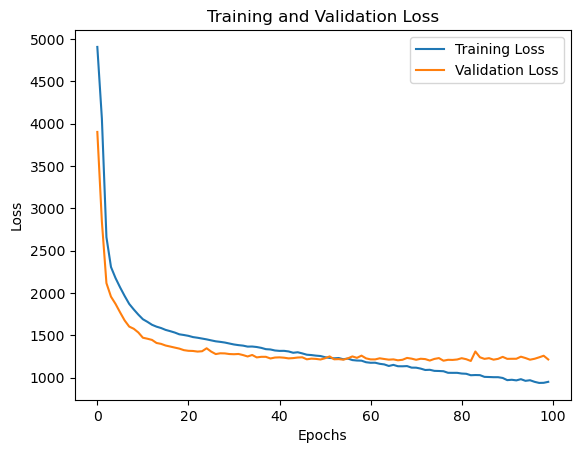

In [16]:

# Plot training loss vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


C:\Users\himan\AppData\Local\Temp\ipykernel_20340\1899136162.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


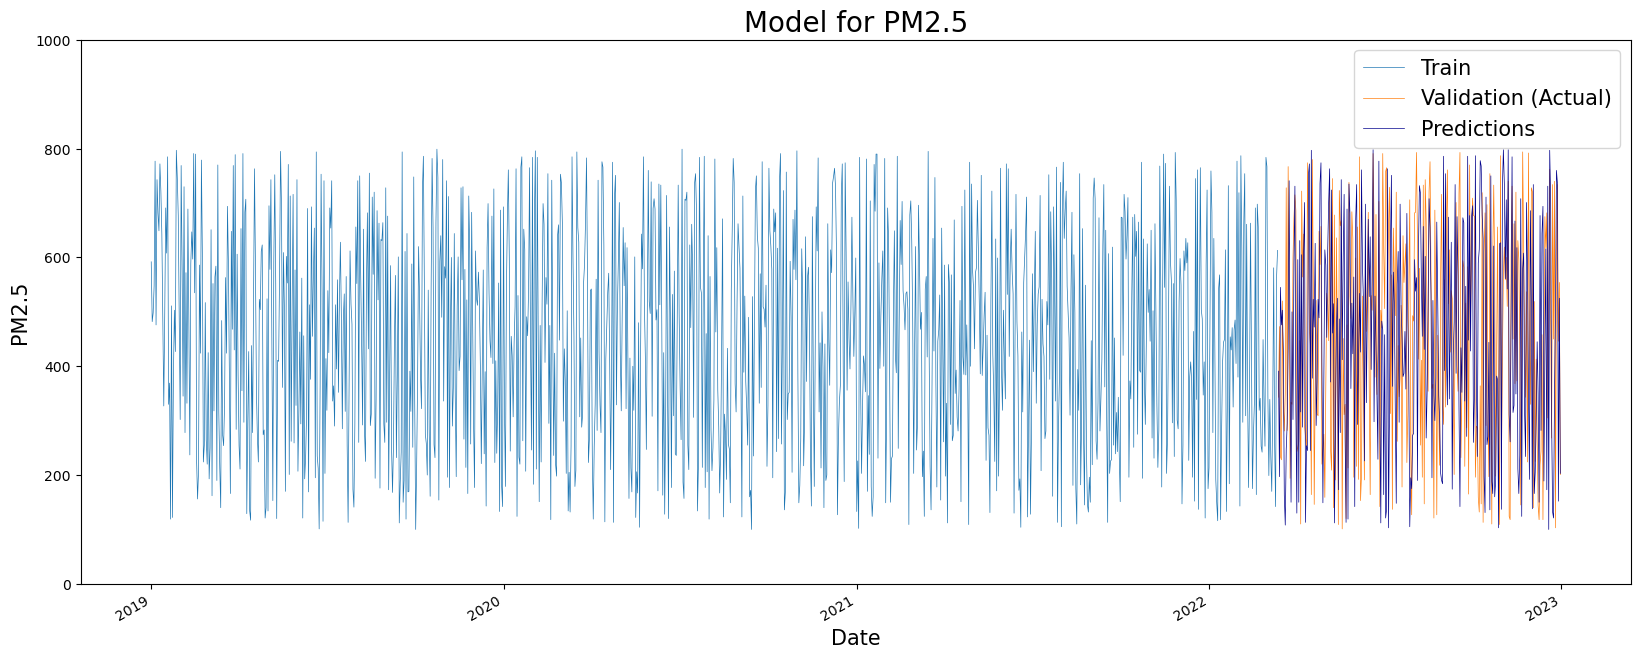

In [17]:
import pandas as pd
import matplotlib.dates as mdates

# Example DataFrame with dates from 2019 to 2024
date_range = pd.date_range(start='1/1/2019', end='31/12/2022')
df_date = pd.DataFrame({
    'Date': date_range,
    'PM2.5': np.random.randint(100, 800, size=len(date_range))
})
df_date.set_index('Date', inplace=True)

# Define the training data length
training_data_len = int(len(df_date) * 0.8)

# Split the data
train = df_date[:training_data_len]
valid = df_date[training_data_len:]

# Example predictions with the correct shape
predictions = np.random.randint(100, 800, size=len(valid))

# Add predictions to the validation set
valid["Predictions"] = predictions

# Plotting
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5", fontsize=20)
plt.xlabel("Date", fontsize=15)
plt.ylabel("PM2.5", fontsize=15)  # Updated y-axis label

# Plot with reduced line thickness
plt.plot(train.index, train['PM2.5'], label='Train', linewidth=0.5)
plt.plot(valid.index, valid['PM2.5'], label='Validation (Actual)', linewidth=0.5)
plt.plot(valid.index, valid["Predictions"], label='Predictions', linewidth=0.5, color='darkblue')

# Format the x-axis to show only the year
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Set y-axis limits
plt.ylim(0, 1000)

plt.legend(fontsize=15)
plt.show()

# END**